# Librerías y configuraciones

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
import time

import matplotlib.pyplot as plt
from os import path

plt.rc('figure', max_open_warning=0)

# Funciones para procesar datos y plottear

In [2]:
def data_processing(df):
    city_name = df.keys()[0]    

    # Reemplazar NaN por 0
    df = df.fillna(0)

    # Eliminar las primeras 3 filas
    df = df.iloc[3:, :]

    # Eliminar las últimas 3 filas
    df = df.iloc[:-2, :]

    # Obtener nombres de estaciones
    stations_names = [item[0] for item in df.iloc[:, :1].values]

    # Eliminar las primeras 2 columnas
    df = df.iloc[:, 2:]

    # Eliminar la última columna
    df = df.iloc[: , :-1]

    # Renombrar columnas e indices
    df.columns = stations_names
    df.index = stations_names

    return df, city_name, stations_names

In [3]:
def make_graph(df):
    rows, cols = np.where(df == 1)
    edges = zip(rows.tolist(), cols.tolist())

    G = nx.Graph()
    G.add_edges_from(edges)
    
    return G

In [4]:
def plot_graph(G, city_name, save=False):
    
    pos = nx.spring_layout(G, seed=5)

    plt.figure(figsize=(15,5))
    ax = plt.gca()
    ax.set_title(f'{ city_name }')

    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)

    if save:
        plt.savefig(f'graph_{city_name}.png')
    
    plt.show()

In [5]:
def plot_attack(G, city_name, save=False):

    # Generar copias para los distintos ataques
    Sd = G.copy()
    Sr = G.copy()

    # Total de nodos
    total_nodos = nx.number_of_nodes(G)

    # Lista desde 0 hasta el total de nodos
    arr_x = list(range(total_nodos))

    arr_y_d = []
    arr_x_d_id = []

    arr_y_r = []
    arr_x_r_id = []

    ### Ataque dirigido
    # Obtener grados
    df_grados = pd.DataFrame(nx.degree(G), index=[station_names], columns=['id', 'degree'])

    # Ordenar por grado
    # df_grados.sort_values(by='degree', ascending=False, inplace=True)
    
    # Ordenar por grado desc e id asc
    df_grados.sort_values(['degree', 'id'], ascending=[False, True], inplace=True)
    
    # Ordenar por grado desc e id desc
    # df_grados.sort_values(['degree', 'id'], ascending=[False, False], inplace=True)

    for idx, row in df_grados.iterrows():

        # Subgrafo temporal para ataque dirigido
        tempS_G = Sd.subgraph(max(nx.connected_components(Sd), key=len))
        nodes_G = nx.number_of_nodes(tempS_G)

        # Guardar la nueva cantidad de nodos
        arr_y_d.append(nodes_G)    

        # Eliminar nodo
        Sd.remove_node(row.id)

        # Guardar el id eliminado
        arr_x_d_id.append(row.id)

    ### Ataque random
    random_ids = list(range(total_nodos))
    # random.seed(3)
    random.shuffle(random_ids)

    for nodo_id in random_ids:

        # Subgrafo temporal para ataque random
        tempS_R = Sr.subgraph(max(nx.connected_components(Sr), key=len))
        nodes_R = nx.number_of_nodes(tempS_R)

        # Guardar la nueva cantidad de nodos    
        arr_y_r.append(nodes_R)

        # Eliminar nodo con ataque random
        Sr.remove_node(nodo_id)

        # Guardar el id eliminado
        arr_x_r_id.append(nodo_id)

    # Pintar
    plt.figure(figsize=(15,5))
    plt.plot(arr_x, arr_y_d, color='r', marker='o', linewidth=1, label = 'Targeted Attack')
    plt.plot(arr_x, arr_y_r, color='k', marker='x', linewidth=0.5, label = "Random Failure")
    plt.xlabel('Number of Nodes Removed')
    plt.ylabel('Size of Largest Connected Component')
    plt.title(city_name)
    plt.legend()
    
    if save:
        plt.savefig(f'attack_{city_name}.png')
        
    plt.show

In [6]:
def plot_radar(df_result, categories, save=False):
    label_loc = np.linspace(0,2 * np.pi, len(categories), endpoint=False)

    for i in list(df_result.index.values):
        city_name = df_result.iloc[i, 0]
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(polar=True)
        ax.plot(label_loc, list(df_result.iloc[i,[3,4,5,6,7,8,9,10,11,12]]), '-', color='c', label=city_name)
        ax.fill(label_loc, list(df_result.iloc[i,[3,4,5,6,7,8,9,10,11,12]]), alpha=0.3, color='c')
        ax.set_thetagrids(np.degrees(label_loc), categories)
        plt.title(city_name)
        
        if save:
            plt.savefig(f'radar_{city_name}.png')
            
        plt.show()

## Funciones de métricas de robustez

In [7]:
def robustness_metrics(df, city_name, g):
    
    data = []
    
    n = g.number_of_nodes()
    l = g.number_of_edges()
    
    data.append(city_name)
    data.append(n)
    data.append(l)
    data.append(robustness_indicator(g, n, l))
    data.append(effective_graph_conductance(g, n))
    data.append(reliability(g))
    data.append(average_efficiency(g, n))
    data.append(clustering_coefficient(g))    
    data.append(algebraic_connectivity(g, n))
    data.append(average_degree(g, n))
    data.append(natural_connectivity(df, g, n))
    data.append(degree_diversity(g))
    data.append(meshedness_coefficient(n, l))
    
    columns = [
        'Metros',
        'N',
        'L',
        'rT',
        'Cg',
        'RelG',
        'E[1/H]',
        'CCg',        
        'μN-1',
        'E[D]',
        'λ',
        '1/k',
        'Mg'
    ]
    
    return pd.DataFrame([data], columns=columns)

###  1. Indicador de robustez rT
Cuantifica la robustez de una red de metro en términos del número de caminos alternativos en la topología de la red dividido por el número total de estaciones en el sistema.

Las redes de tránsito suelen estar conectadas y, por lo tanto, P=1. El número total de estaciones, Ns en el denominador, representa la probabilidad de fallo; es decir, cuanto más grande sea el sistema, más estaciones habrá que mantener y, por lo tanto, más probable será que una estación falle.

In [8]:
def robustness_indicator(g, n, l):
    
    rT1 = np.log(l-n+2)/n
    
    # Normalizar    
    Lmax = n*(n-1)/2    
    rT2 = np.log(Lmax-n+2)/n
    rT =rT1/rT2
    
    return round(rT, 3)

### 2. Conductancia efectiva del grafo CG

La resistencia efectiva del grafo RG capta la robustez de una red incorporando el número de caminos paralelos (es decir, la redundancia) y la longitud de cada camino entre cada par de nodos. La existencia de caminos paralelos entre dos nodos en las redes de metro y una distribución heterogénea de la longitud de cada camino dan como resultado una menor resistencia efectiva del grafo y un nivel de robustez potencialmente mayor.

En este caso, un mayor CG indica un mayor nivel de robustez. La CG normalizada permite comparar la robustez de la red entre diferentes ciudades con distinto tamaño de metro.

In [9]:
def effective_graph_conductance(g, n):
    
    # Matriz laplaciana
    mlp = nx.laplacian_matrix(g)

    # Obtener valores propios y convertir a arreglo
    evs = np.linalg.eigvals(mlp.A)

    # Conservar valores mayores a 0
    evs = evs[evs > 0.1]
            
    Rg = n * np.sum(1/evs)
    Cg = (n-1) / Rg
    
    # Redondear y quitar valores complejos
    return np.round(Cg.real, 2)

### 3. Fiabilidad
La fiabilidad RelG de una red es la probabilidad de que la red esté conectada dadas las probabilidades de fallo de sus componentes. En esencia, capta la robustez calculando la fracción de tiempo que cada estación es accesible desde cualquier otra estación. El inconveniente de utilizar la fiabilidad es que considera que las redes son totalmente operativas o fallidas y no proporciona ninguna distinción más fina. Se utiliza un valor constante de 0.999 dada la ausencia de datos reales de fiabilidad.

In [10]:
def reliability(g):
    
    return 0.999

### 4. Eficacia media E[1/H]
En número de saltos Hij es el número de enlaces en el camino más corto entre el nodo i y el nodo j.

In [11]:
def average_efficiency(g, n):
    
    total = 0
    # Iterar sobre los nodos i, j
    for i in g.nodes():
        for j in g.nodes():
          if i < j:
            total = (total + 1 / nx.shortest_path_length(g, source=i, target=j))
    E = 2 * total / (n * (n-1))

    return round(E.real, 2)

### 5. Coeficiente de agrupación (Clustering) CCG
El coeficiente de clustering evalúa cómo los vecinos de un nodo están conectados entre sí.

In [12]:
def clustering_coefficient(g):
   
    return round(nx.average_clustering(g), 2)

### 6. Conectividad algebraica μN−1
La conectividad algebraica μN−1 es el segundo valor propio más pequeño de la matriz laplaciana de un gráfico. Por tanto, un valor alto de la conectividad algebraica indica una red más robusta. Además, implica una fuerte sincronía en las redes de transporte y una mayor dificultad para romper las redes de transporte aéreo bajo fallos aleatorios.


In [13]:
def algebraic_connectivity(g, n):

    # Matriz laplaciana
    mlp = nx.laplacian_matrix(g)
    
    # Obtener valores propios y convertir a arreglo
    evs = np.linalg.eigvals(mlp.A)
        
    # Ordenamos, obtenemos el segundo elemento y normalizamos
    alg_conn = np.sort(evs)[1] / n
    
    return np.round(alg_conn.real, 3)

### 7. Grado medio E[D]
El grado medio mide el número de conexiones medias de un nodo. Un grafo con un grado medio más alto puede considerarse más robusto, ya que implica más conexiones (es decir, mayor conectividad).
    

In [14]:
def average_degree(g, n):
    
    # Obtener los grados de la columna 2
    arr_degree = pd.DataFrame(nx.degree(g)).iloc[:,1]
    
    # Sumatoria de grados    
    sum_degree = np.sum(arr_degree)
    
    # Calcular promedio
    avg_degree = sum_degree / (n*(n-1))   
    
    return round(avg_degree, 2)

### 8. Conectividad natural λ
La conectividad natural caracteriza la redundancia de las rutas alternativas y se considera una medida de robustez estructural. La conectividad natural es una función monótona del valor propio λi que es sensible incluso a un solo fallo de enlace. En consecuencia, cuando los enlaces fallan uno a uno, la conectividad natural es capaz de capturar cada uno de los fallos, en contraste con, por ejemplo, la conectividad de los enlaces que podría ser la misma para ciertos fallos de enlaces. Se normaliza la conectividad natura para comparar grafos con diferentes tamaños.

In [15]:
def natural_connectivity(df, g, n):

    # Matriz de adyacencia
    madj = nx.linalg.graphmatrix.adjacency_matrix(G).todense()
    
    # Obtener valores propios
    evs = np.linalg.eigvals(madj)
    
    # Formula
    nat_conn = np.log(np.sum(np.exp(evs))/n) / (n-np.log(n))
    
    return np.round(nat_conn.real, 2)

### 9. Diversidad de grado κ (second-order average degree)
It has been shown that κ positively relates to the percolation threshold pc [49] via 1 − pc = 1
κ−1 in the percolation
model. The higher κ is, the more nodes need to be removed to disintegrate a network. In addition, the robustness of dynamic
processes, e.g. epidemic spread, in a network relates to κ regarding the epidemic threshold [50], where below the epidemic
threshold the network is safeguarded from long-term infection. As for homogeneous networks, such as regular graphs where
each node has the same degree, the degree diversity tends to the average degree, κ → E[D]. However, for scale-free networks
with N → ∞, the degree diversity tends to the infinity, κ → ∞. In order to scale the value of the degree diversity in the
interval [0, 1], we take the inverse of the degree diversity.

In [16]:
def degree_diversity(g):
    
    # Obtener los grados de la columna 2
    arr_degree = pd.DataFrame(nx.degree(g)).iloc[:,1]
    
    # Sumatoria de grados    
    sum_degree_1 = np.sum(arr_degree)
    
    # Segunda sumatoria de grados
    sum_degree_2 = np.sum(np.power(arr_degree,2))
    
    # Normalizar
    dd = sum_degree_1 / sum_degree_2    
    
    return round(dd, 2)

### 10. Coeficiente de malla MG
La medida de la estructura de los ciclos en un grafo planar dividiendo el número real de ciclos por el número potencial de ciclos. Se ha utilizado especialmente para caracterizar las propiedades estructurales de las redes de calles urbanas. La diferencia entre el coeficiente de malla MG y el indicador de robustez rT radica en el denominador. El indicador de robustez rT considera el número de estaciones en el denominador, mientras que MG considera el número máximo de caras en un grafo plano. El coeficiente de malla MG satisface 0 ≤ MG ≤ 1, donde 0 se obtiene en un gráfico de árbol con L = N - 1 y 1 se alcanza en los gráficos planares máximos con L = 3N - 6.

In [17]:
def meshedness_coefficient(n, l):
    
    mc = (l-n+1) / (2*n-5)
    
    return round(mc, 2)

# Métricas de Robustez

In [18]:
%%time

# Utilizar las métricas previamente calculados
filename = 'metrics.csv'

if (not path.exists(filename)):
    
    dfAll = pd.read_excel('Metro_Networks_Adjacency.xlsx', sheet_name=None, index_col=None)

    data_df = []

    for idx, city_name in enumerate(dfAll.keys()):

        df = pd.read_excel('Metro_Networks_Adjacency.xlsx', sheet_name=idx, index_col=None)
        df, city_name_2, station_names = data_processing(df)
        G = make_graph(df)
        data_df.append(robustness_metrics(df, city_name, G))

    result = pd.concat(data_df)    
    
    result['ID'] = range(len(result))
    
    result.to_csv(filename, index=False)


result = pd.read_csv(filename, index_col=['ID'])

# Ordenados por Cg descendiente
result = result.sort_values(by='Cg', ascending=False)

result

CPU times: user 4.77 s, sys: 210 ms, total: 4.98 s
Wall time: 5.12 s


,Metros,N,L,rT,Cg,RelG,E[1/H],CCg,μN-1,E[D],λ,1/k,Mg
ID,,,,,,,,,,,,,
24,Rome,5,4,0.000,0.25,0.999,0.70,0.00,0.200,0.40,0.22,0.40,0.00
7,Cairo,6,5,0.000,0.17,0.999,0.62,0.00,0.073,0.33,0.18,0.45,0.00
15,Marseille,6,5,0.000,0.17,0.999,0.62,0.00,0.073,0.33,0.18,0.45,0.00
9,Delhi,8,7,0.000,0.12,0.999,0.57,0.00,0.044,0.25,0.14,0.37,0.00
23,Prague,9,9,0.206,0.12,0.999,0.57,0.06,0.061,0.25,0.15,0.33,0.08
13,Lyon,10,10,0.192,0.11,0.999,0.53,0.00,0.048,0.22,0.12,0.36,0.07
0,Athens,9,9,0.206,0.11,0.999,0.54,0.09,0.031,0.25,0.14,0.38,0.08
4,Brussels,9,9,0.206,0.11,0.999,0.55,0.09,0.034,0.25,0.14,0.38,0.08
18,Montreal,10,10,0.192,0.11,0.999,0.53,0.00,0.048,0.22,0.12,0.36,0.07


# Grafos de todas las redes

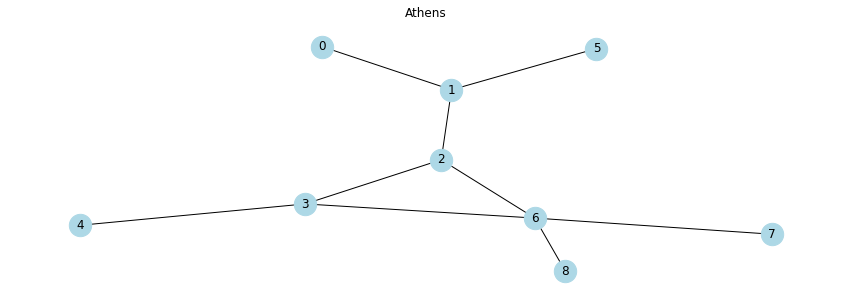

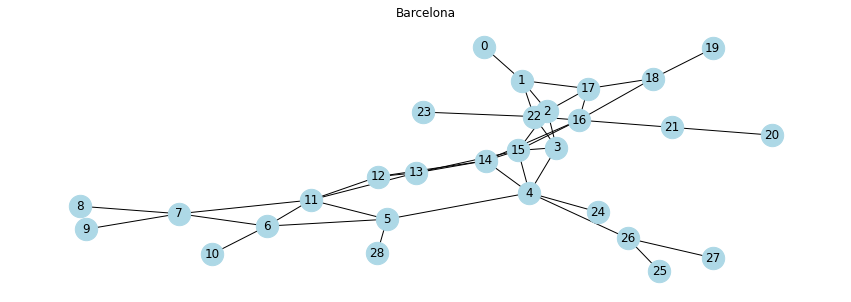

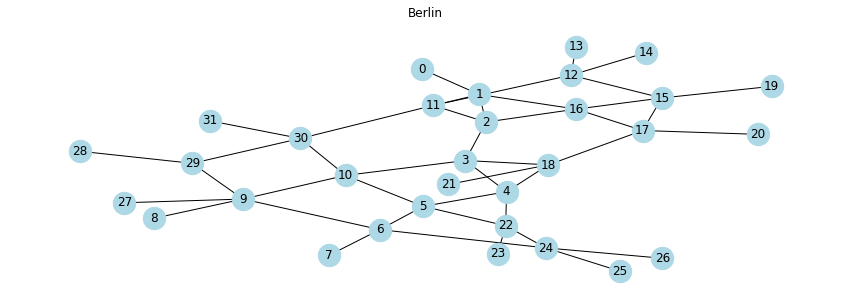

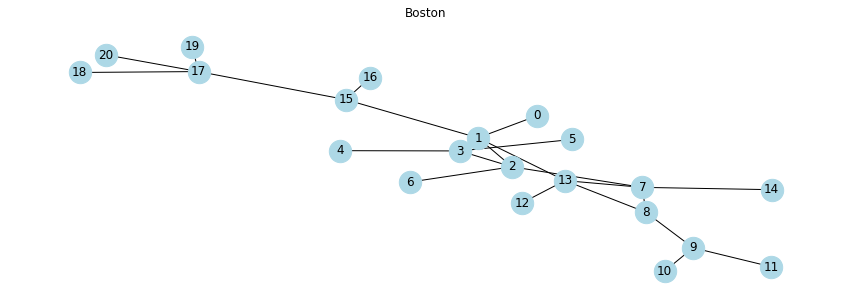

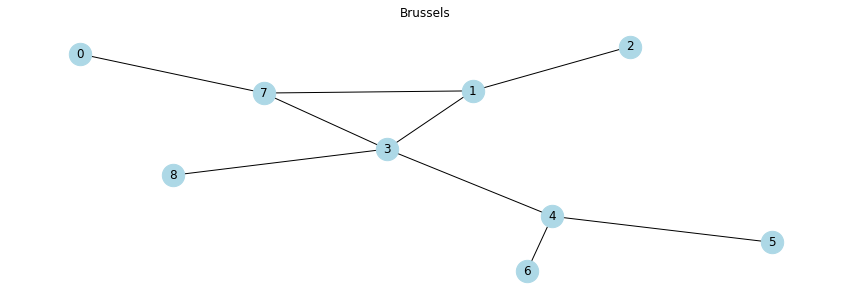

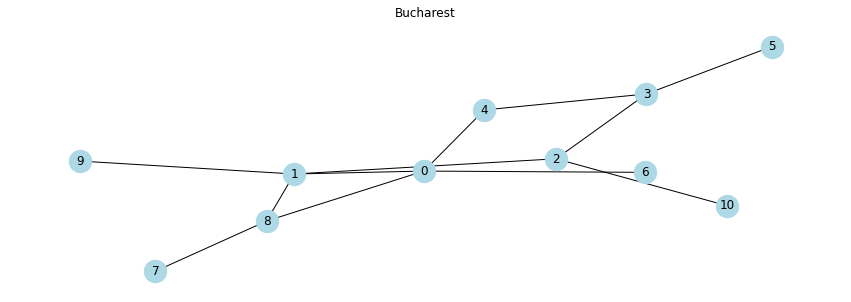

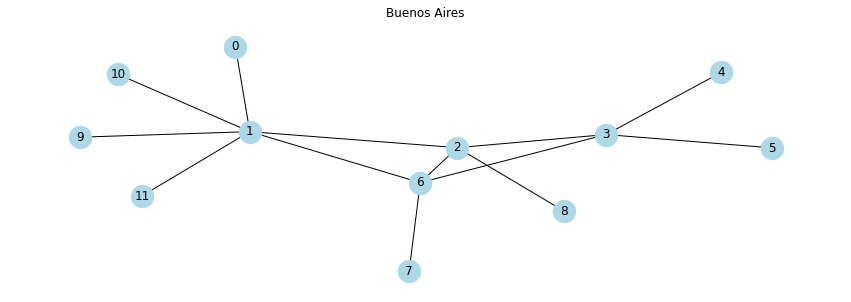

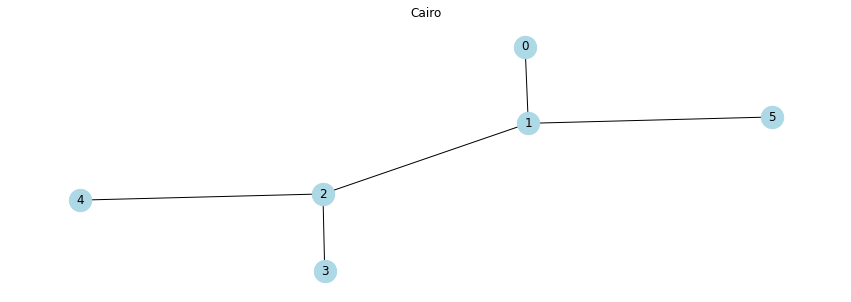

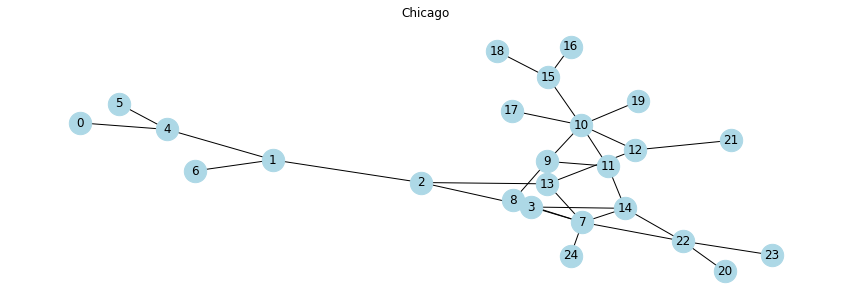

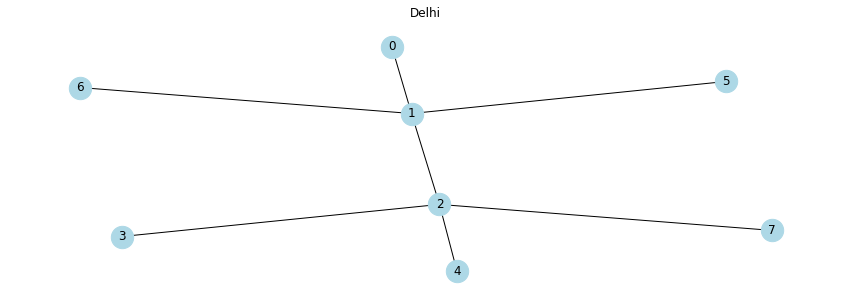

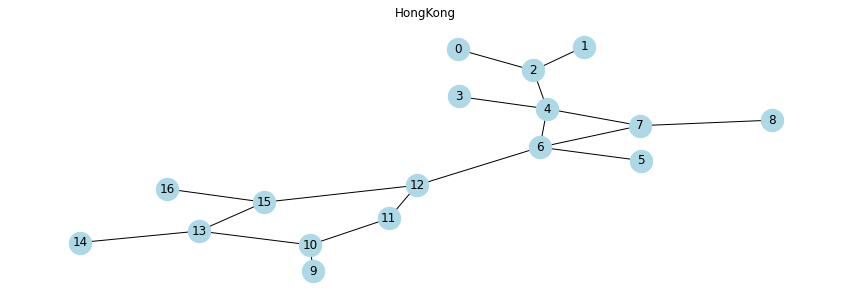

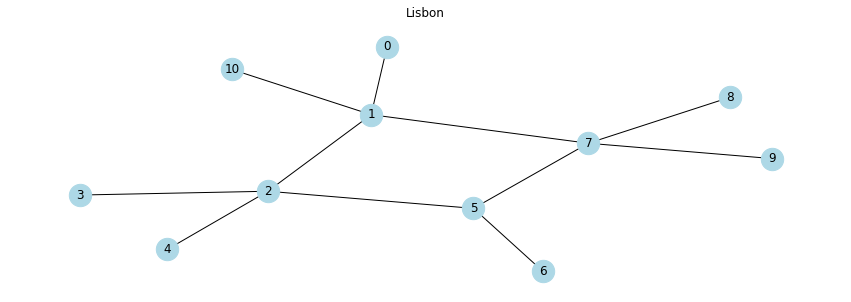

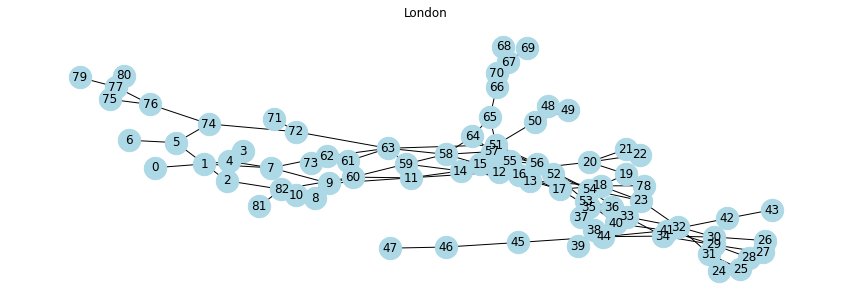

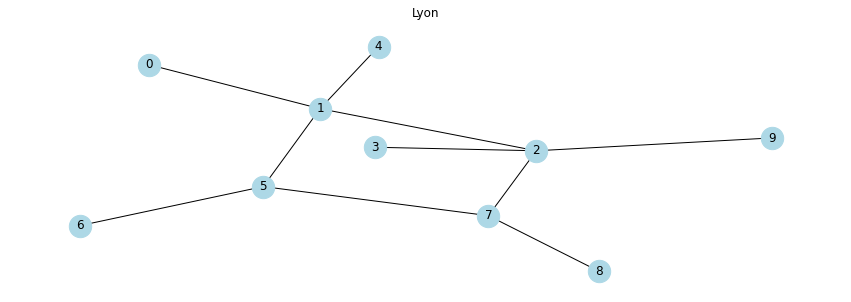

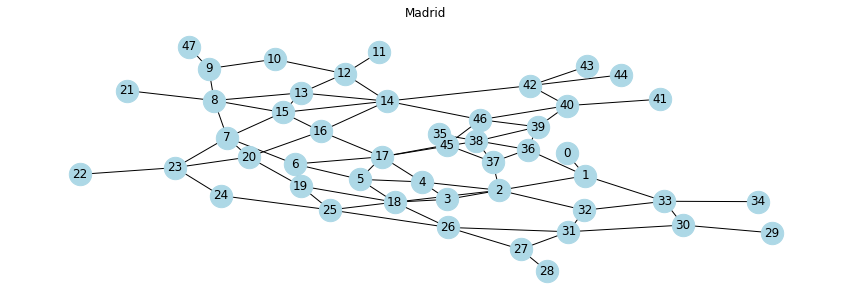

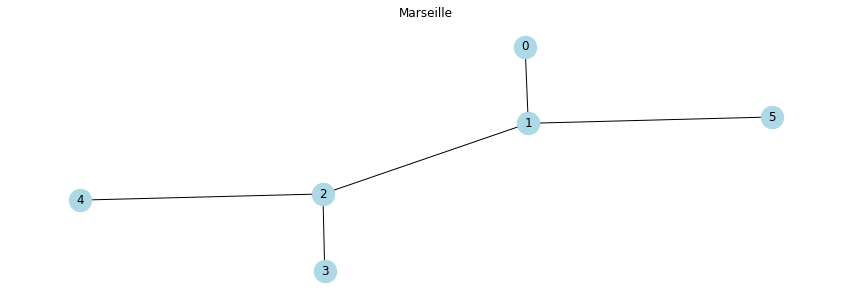

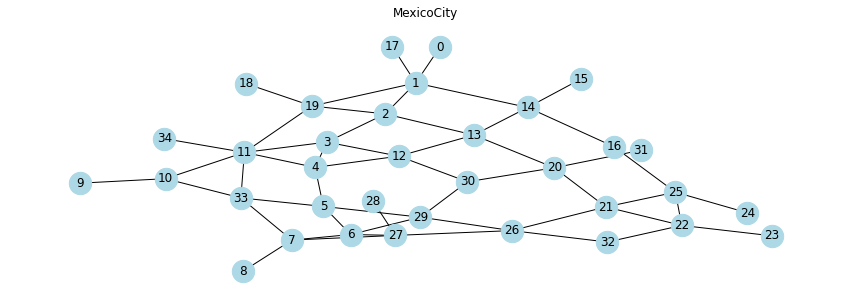

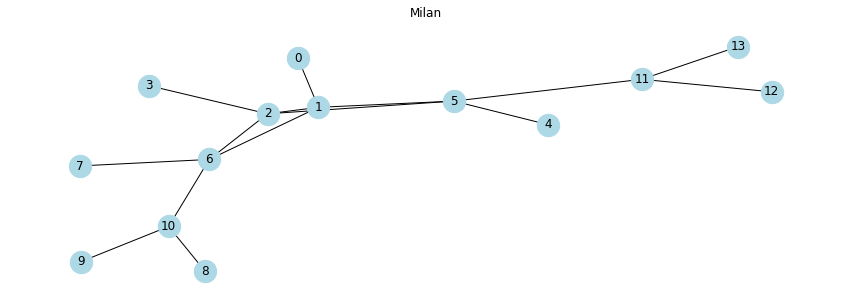

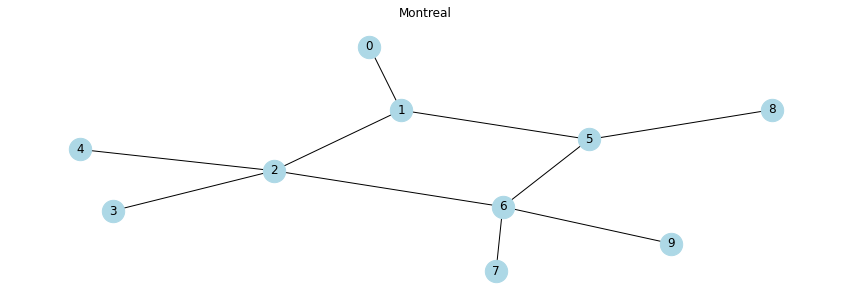

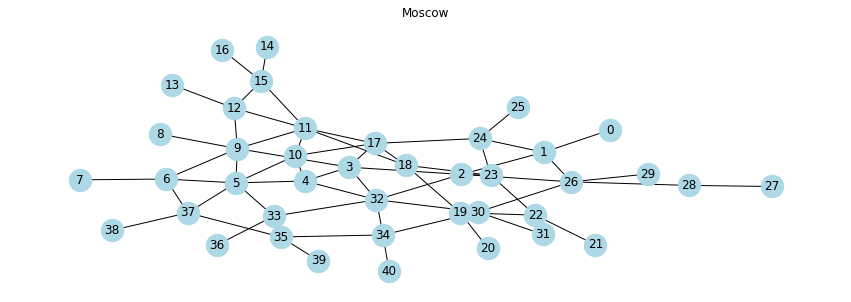

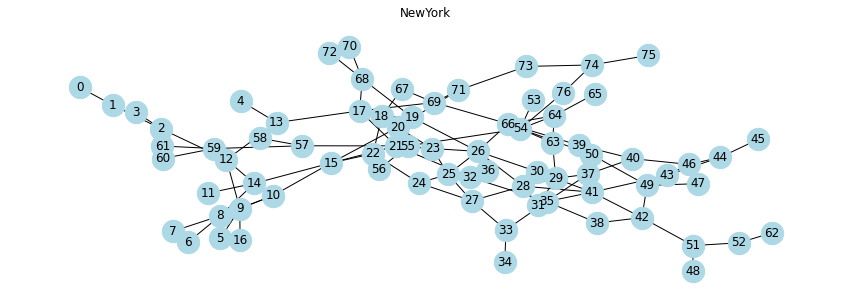

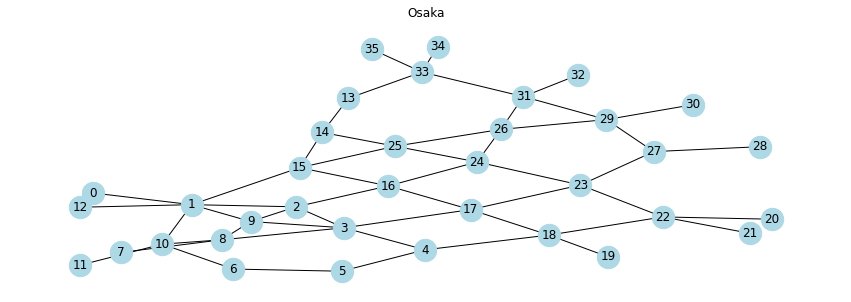

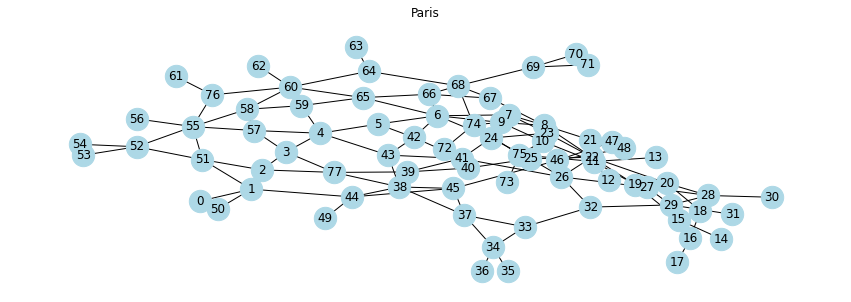

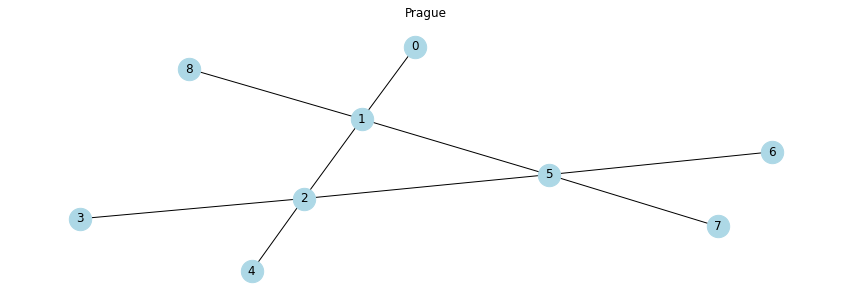

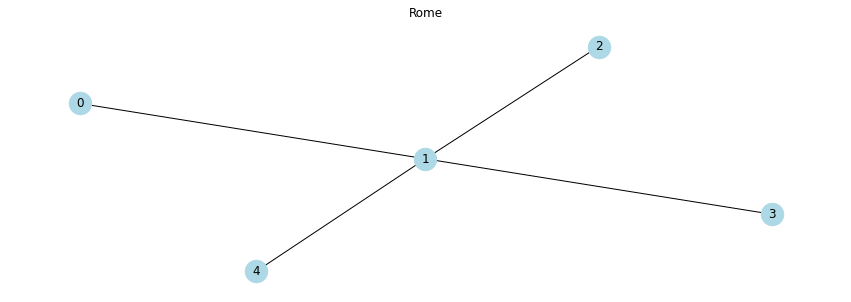

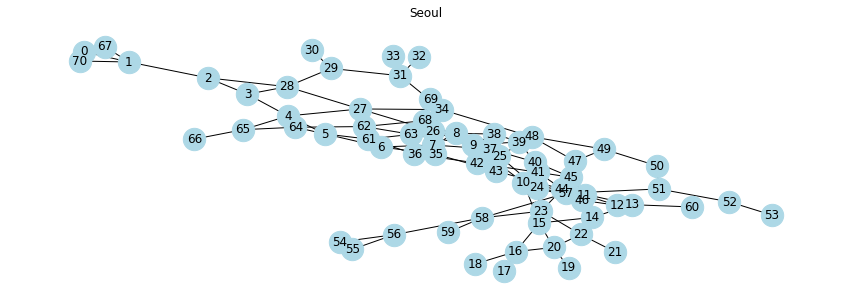

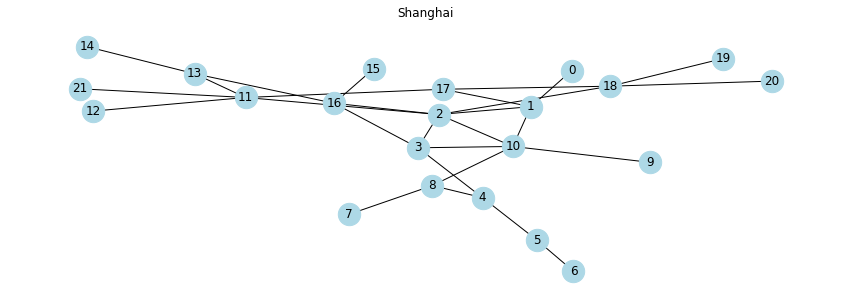

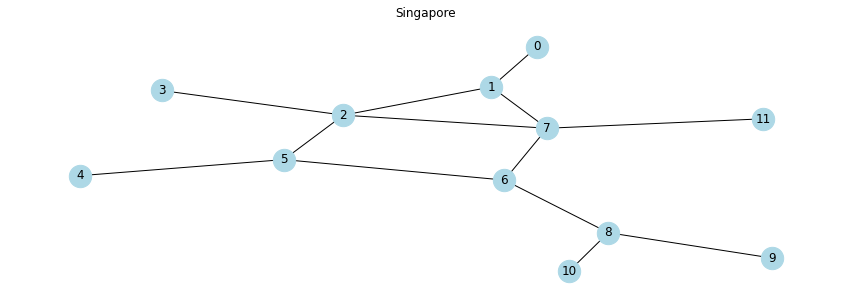

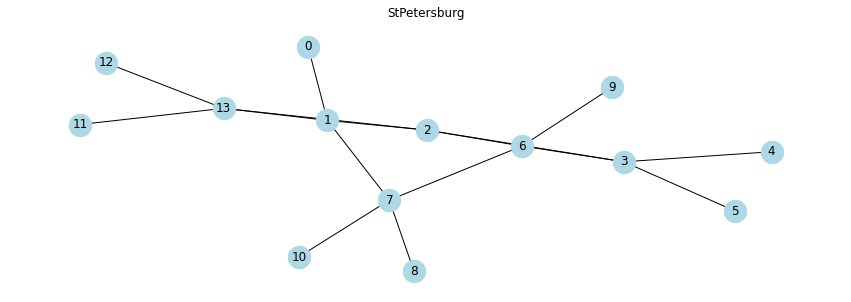

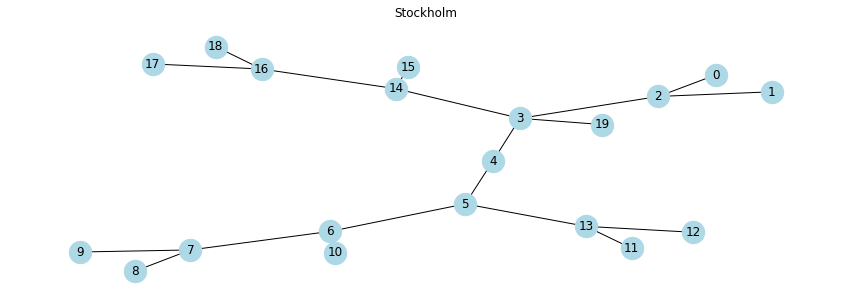

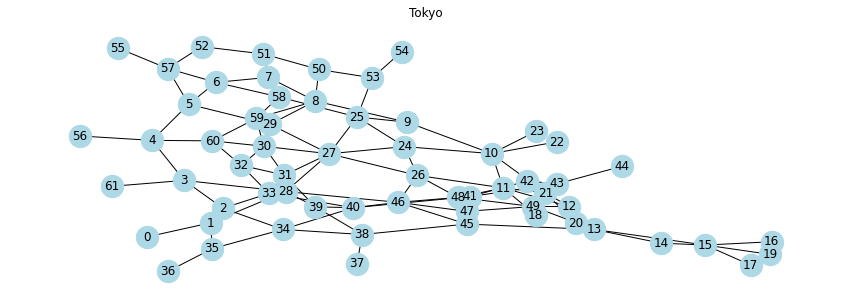

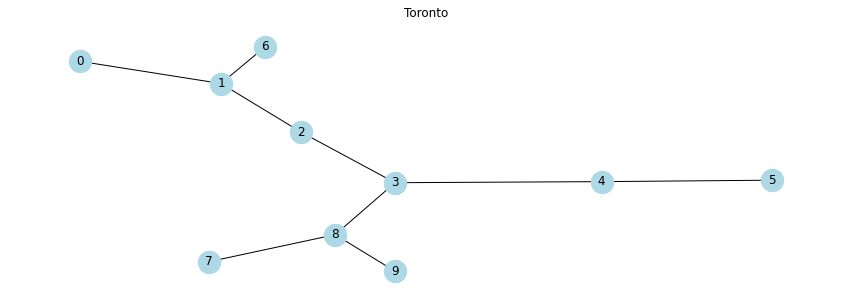

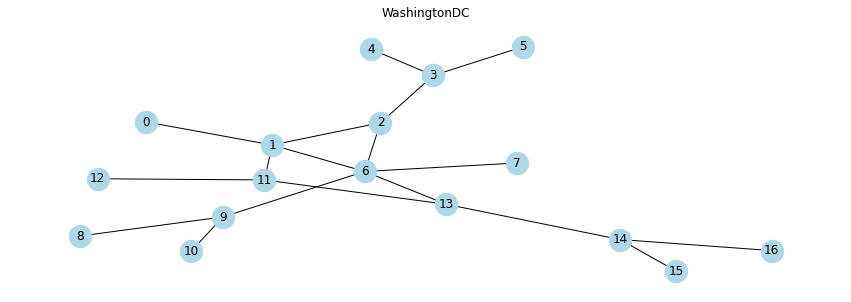

CPU times: user 16.1 s, sys: 1.64 s, total: 17.7 s
Wall time: 11.4 s


In [19]:
%%time

dfAll = pd.read_excel('Metro_Networks_Adjacency.xlsx', sheet_name=None, index_col=None)

for idx, city_name in enumerate(dfAll.keys()):

    df = pd.read_excel('Metro_Networks_Adjacency.xlsx', sheet_name=idx, index_col=None)
    df, city_name_2, station_names = data_processing(df)

    plot_graph(make_graph(df), city_name, save=True)

# Ataques dirigidos y randómicos

CPU times: user 13.9 s, sys: 1.6 s, total: 15.5 s
Wall time: 9.09 s


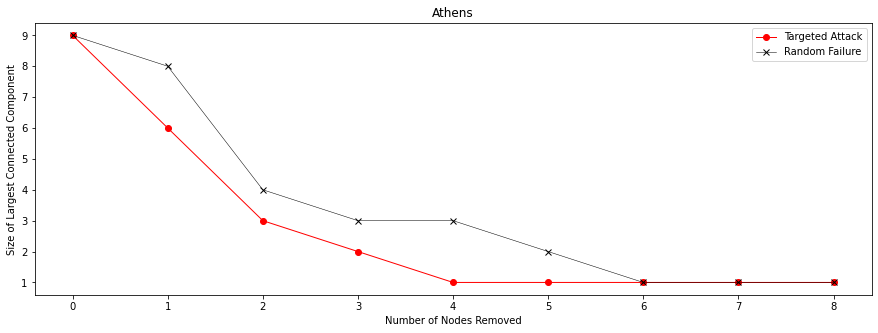

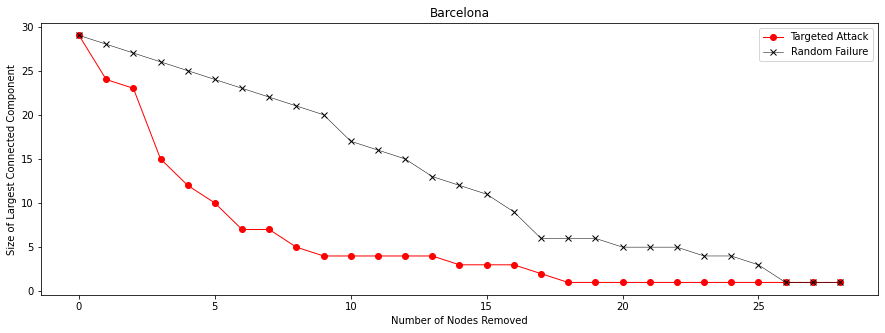

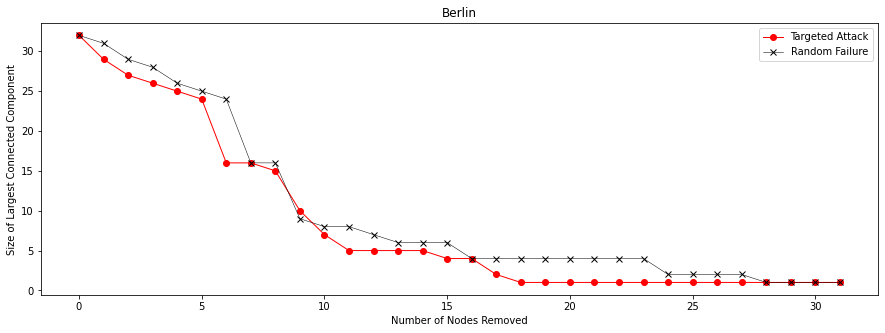

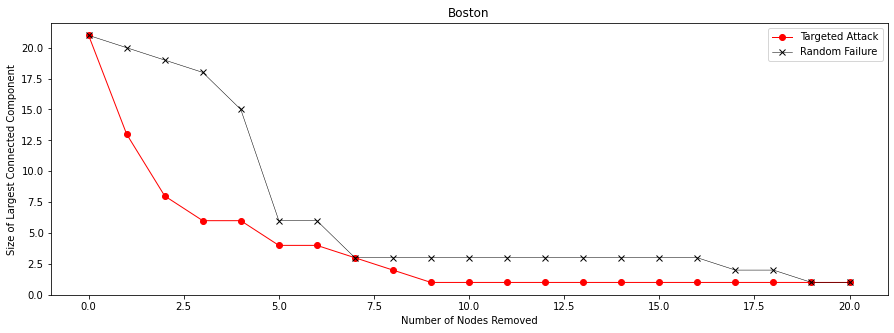

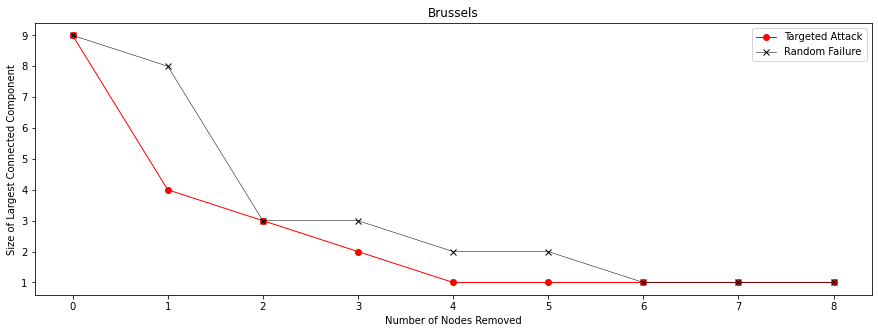

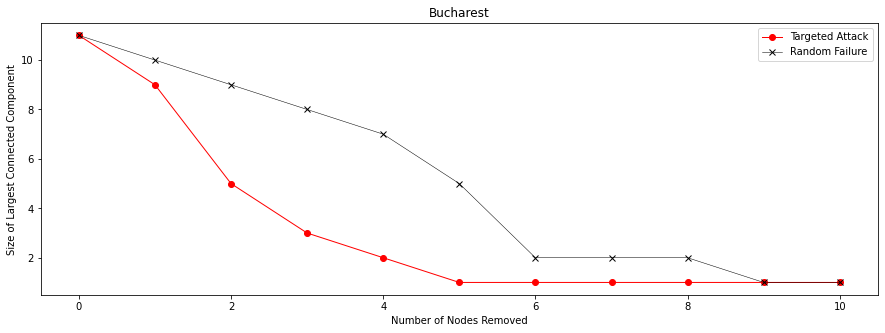

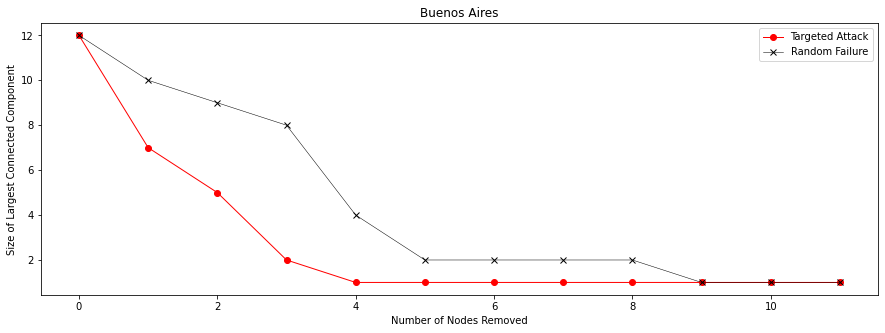

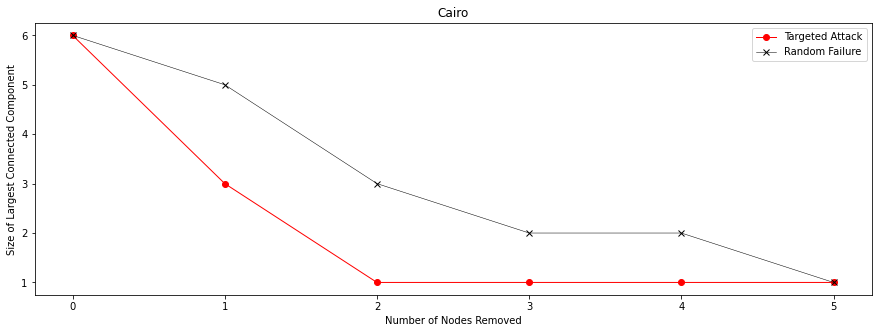

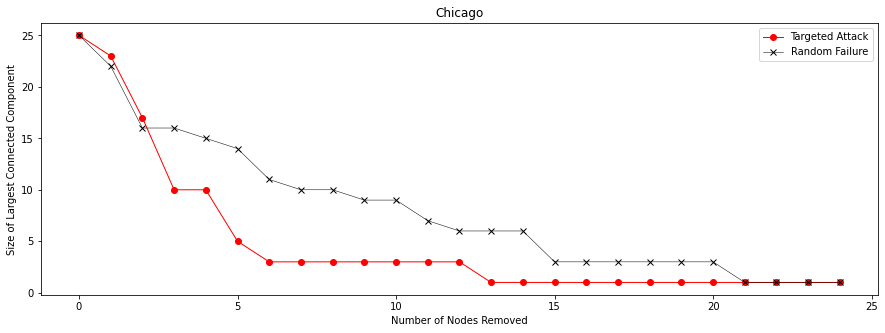

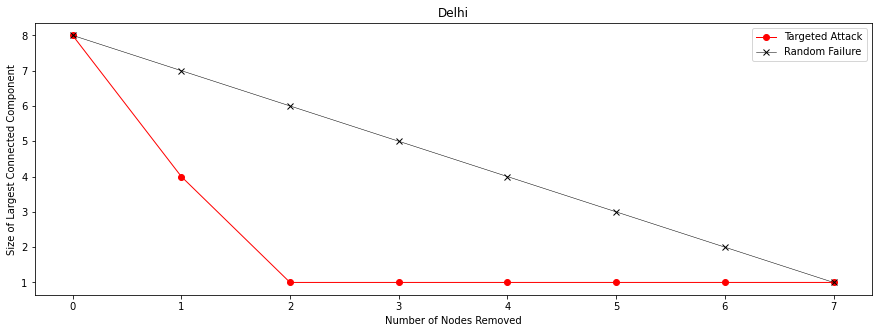

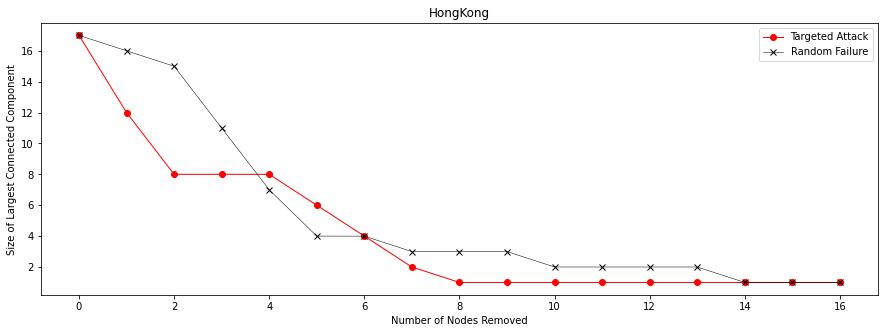

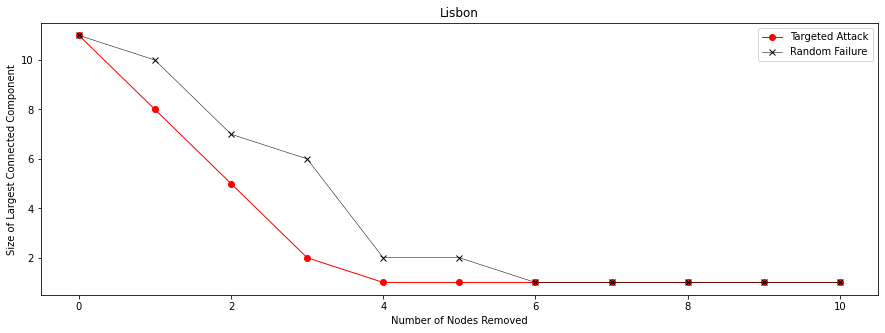

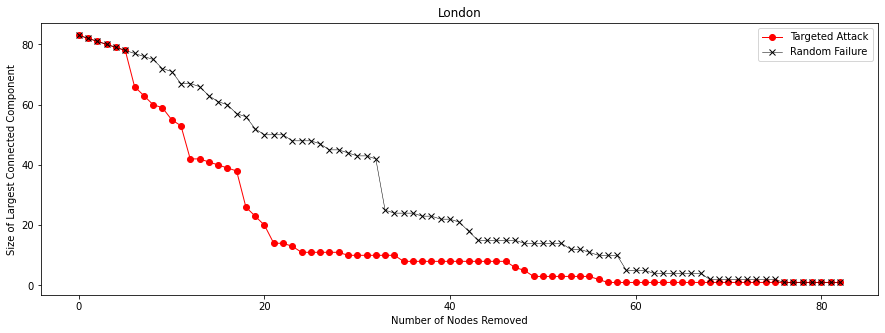

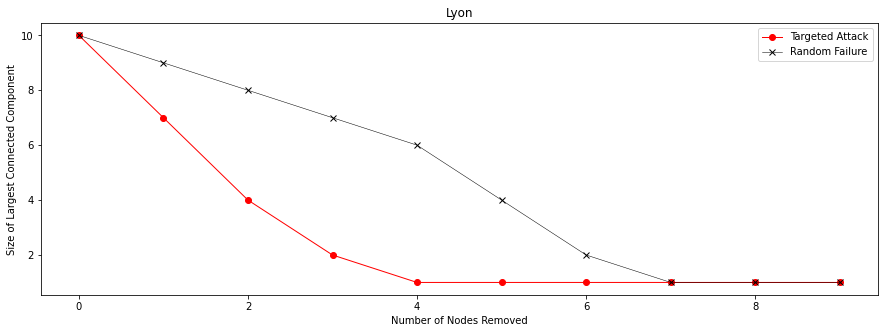

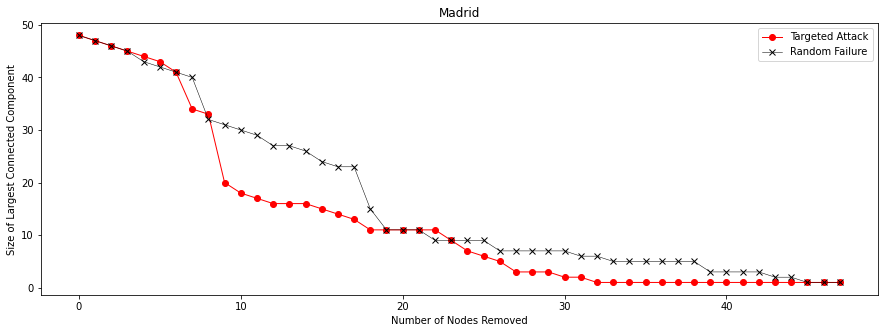

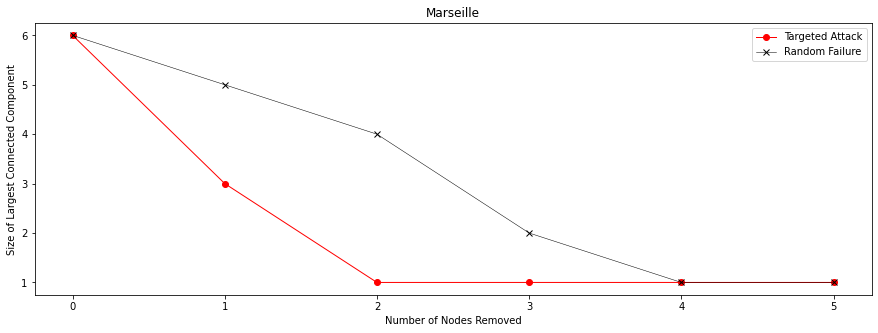

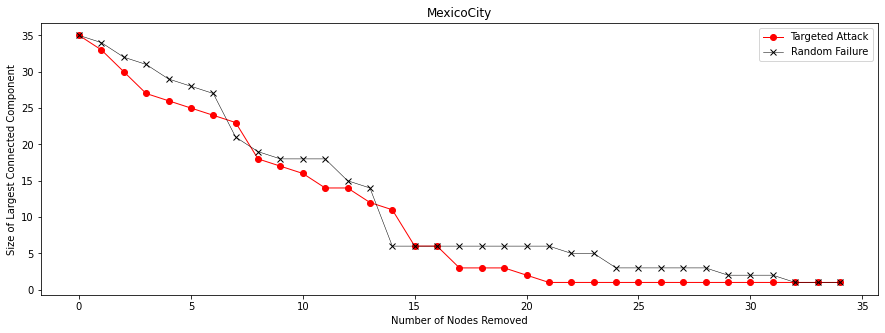

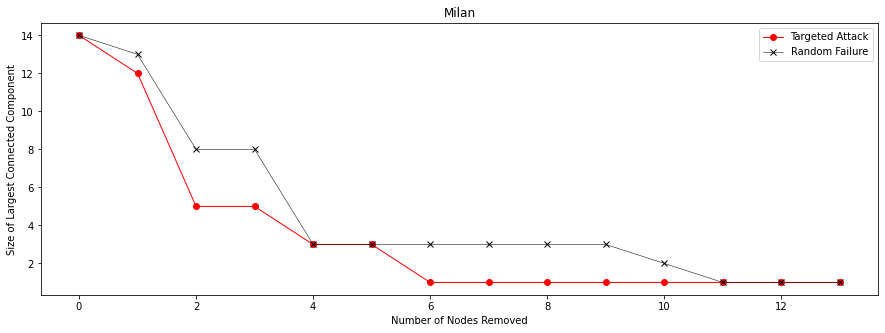

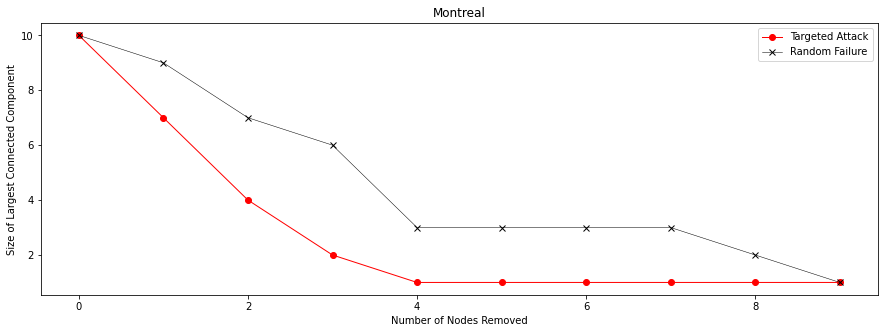

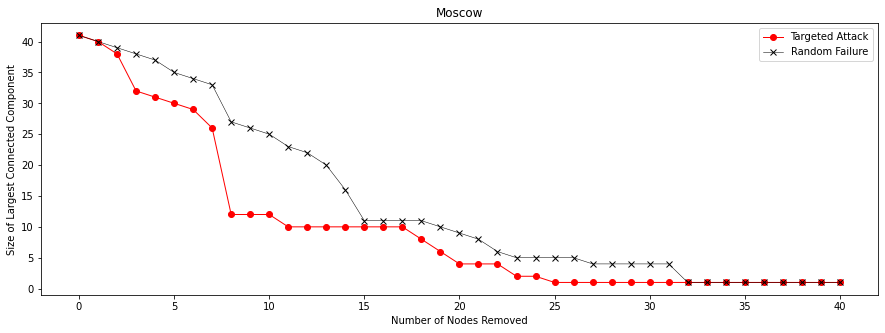

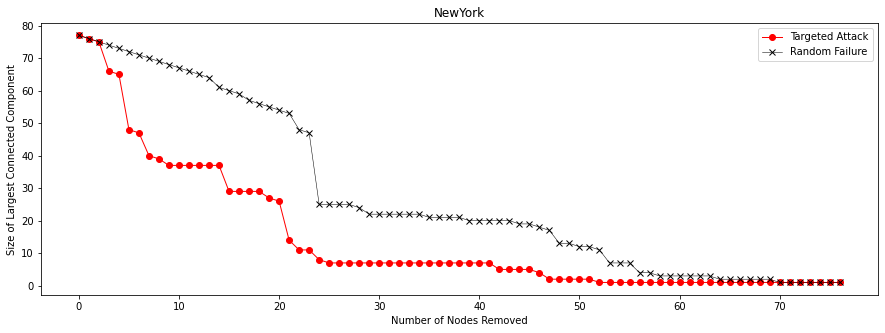

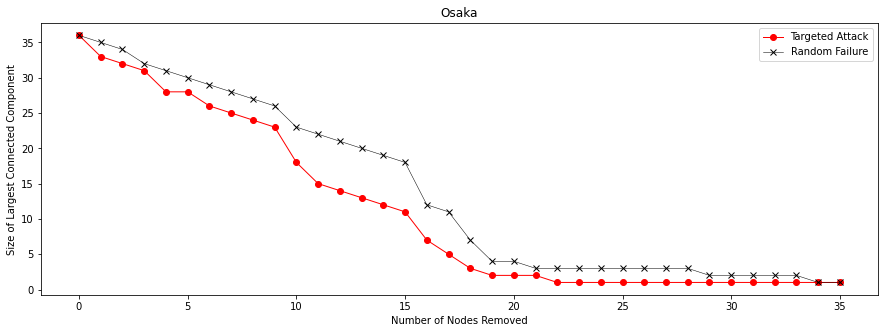

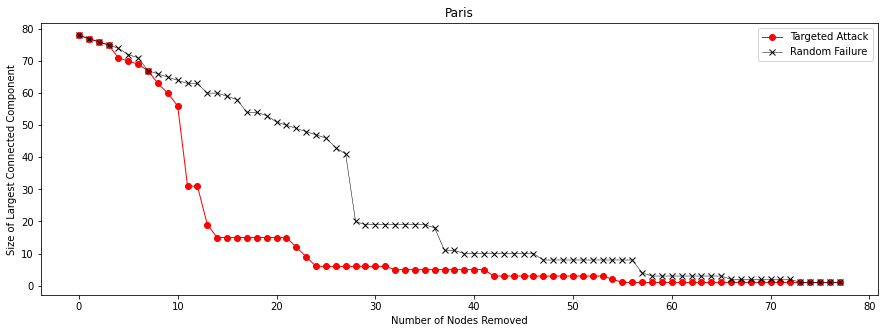

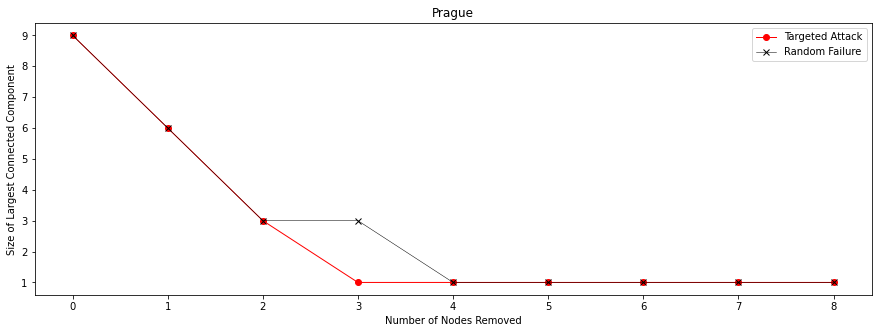

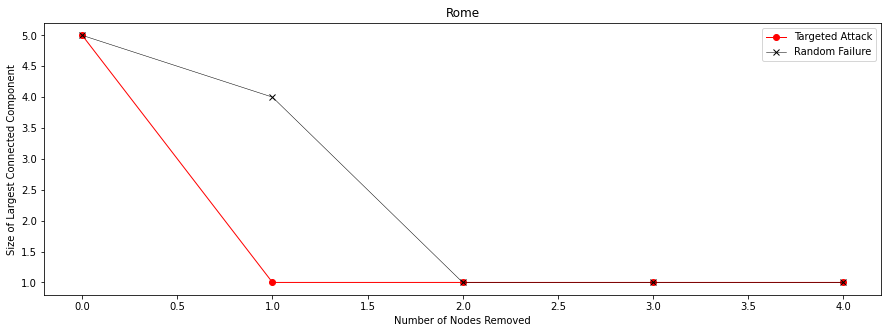

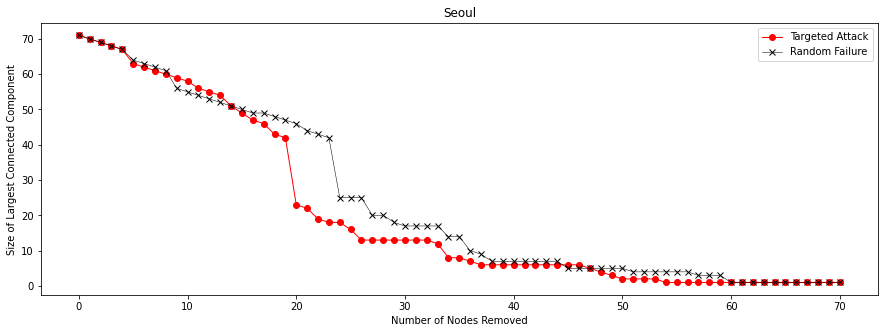

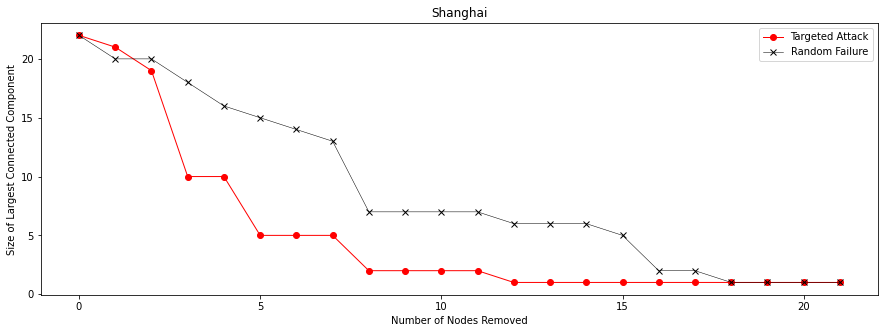

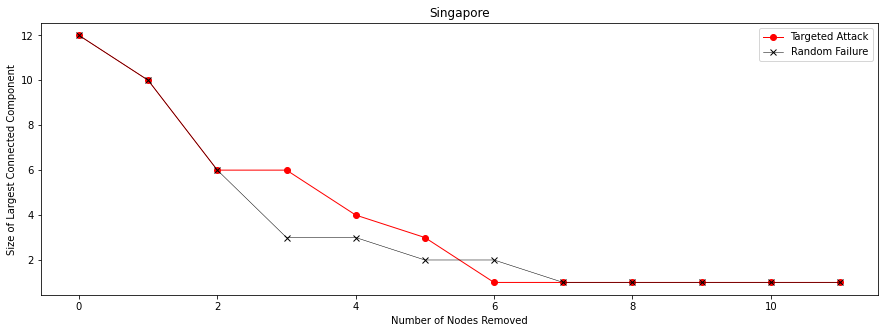

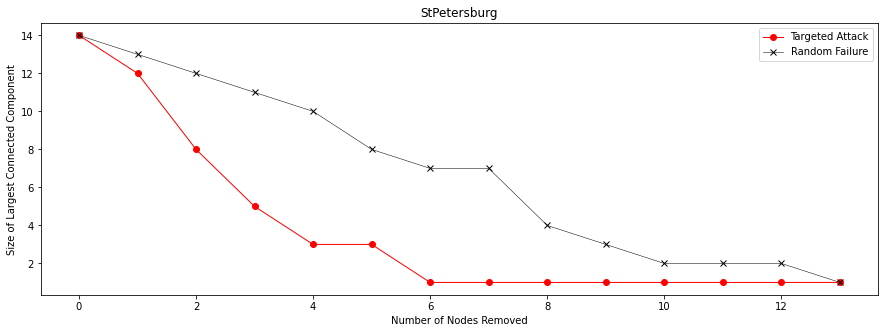

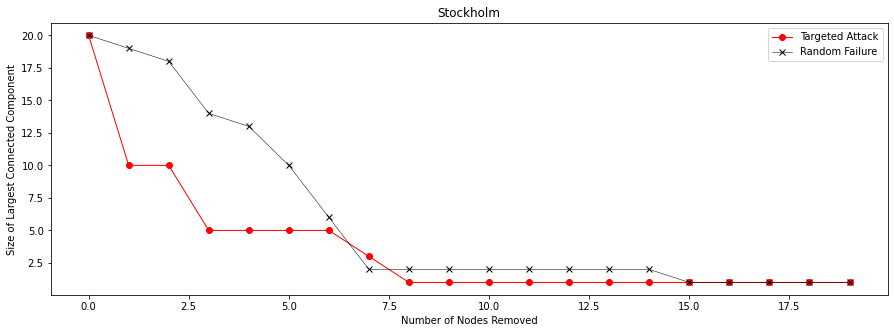

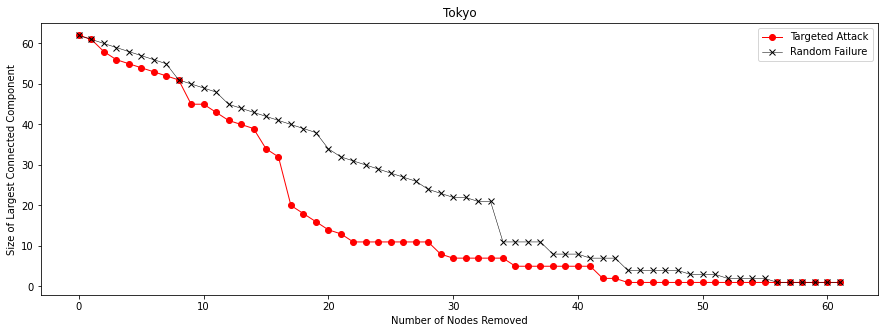

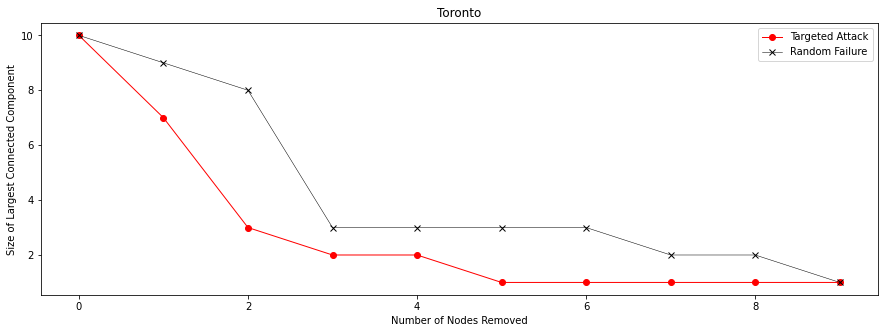

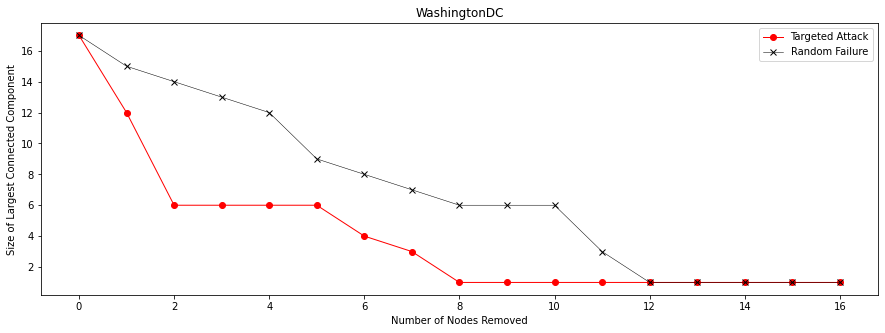

In [20]:
%%time

dfAll = pd.read_excel('Metro_Networks_Adjacency.xlsx', sheet_name=None, index_col=None)

for idx, city_name in enumerate(dfAll.keys()):

    df = pd.read_excel('Metro_Networks_Adjacency.xlsx', sheet_name=idx, index_col=None)    
    
    df, city_name_2, station_names = data_processing(df)
    G = make_graph(df)
    
    plot_attack(make_graph(df), city_name, save=True)

# Gráficos de radar

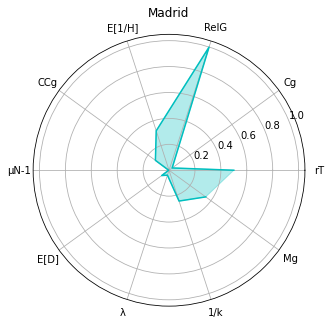

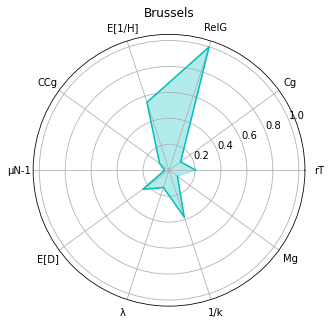

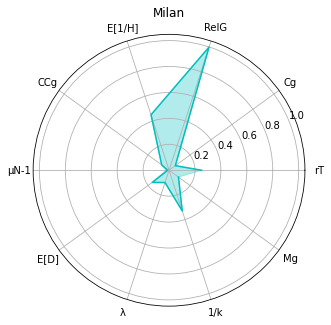

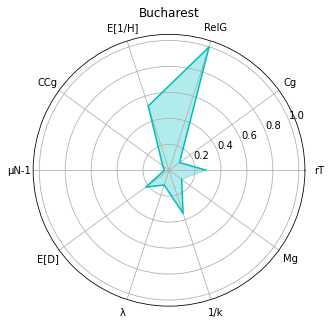

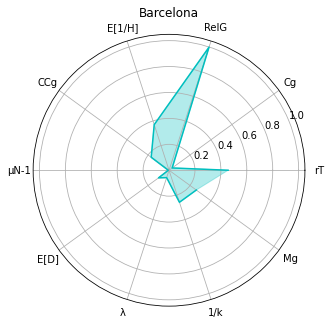

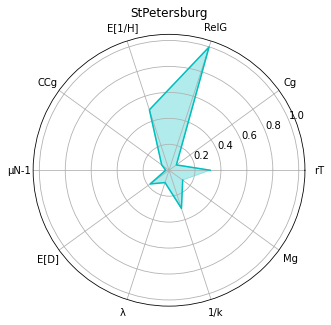

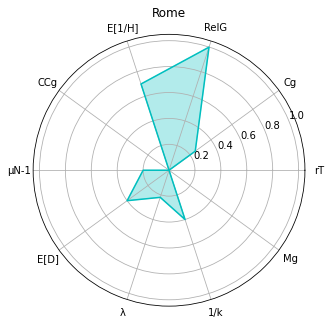

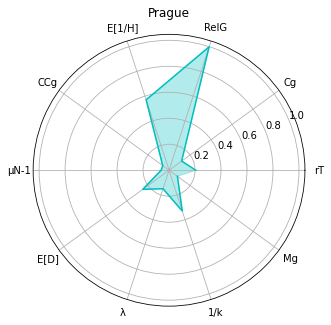

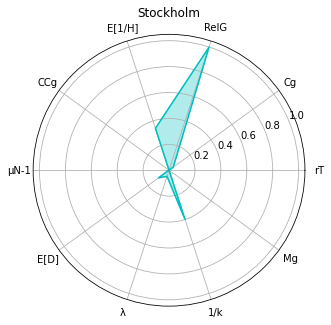

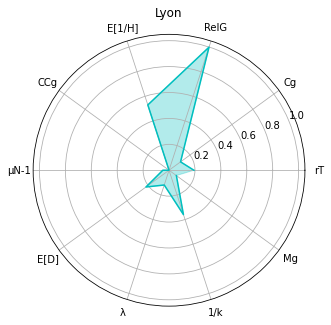

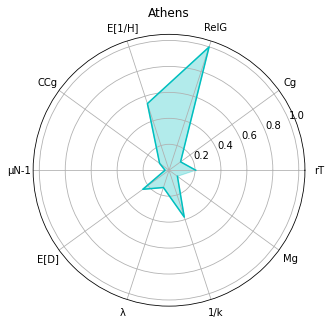

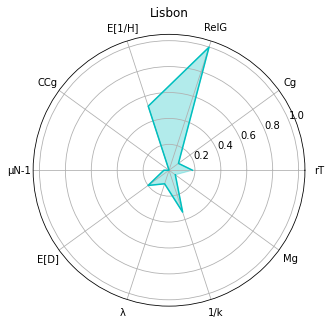

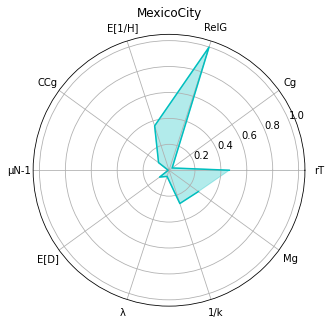

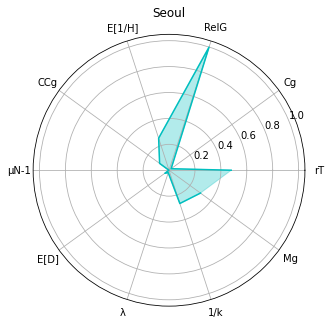

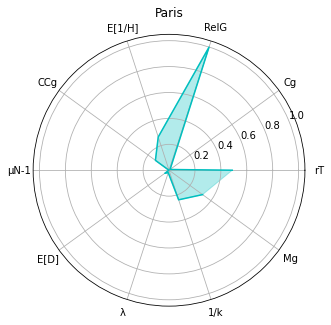

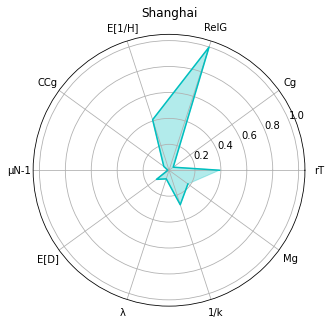

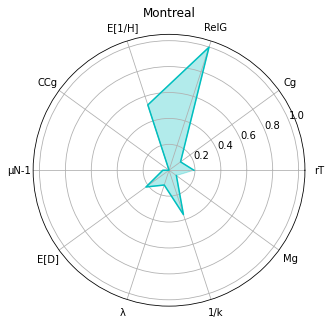

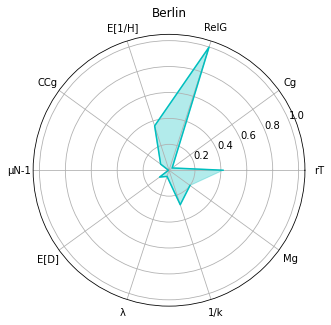

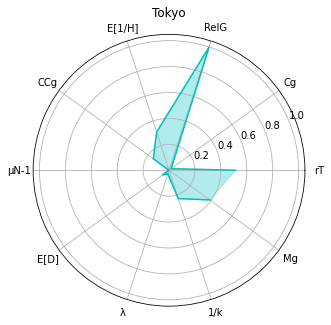

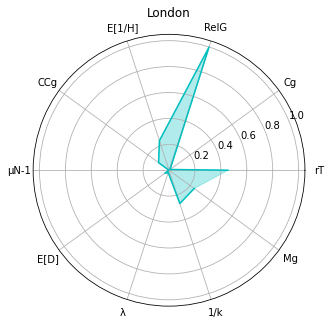

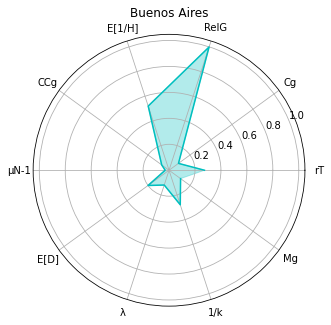

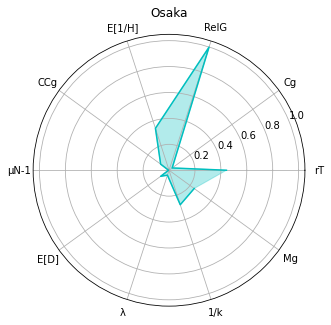

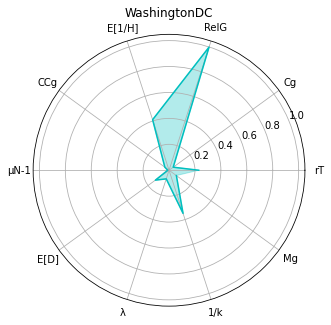

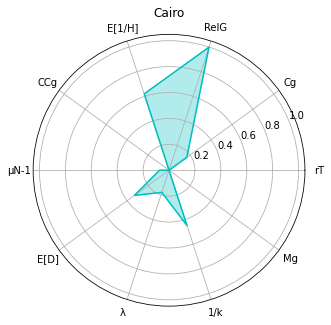

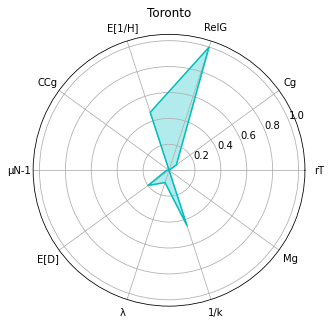

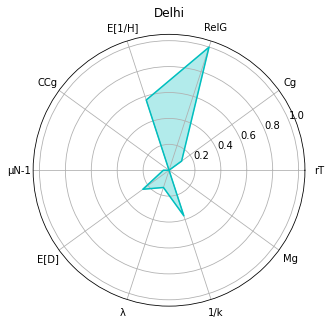

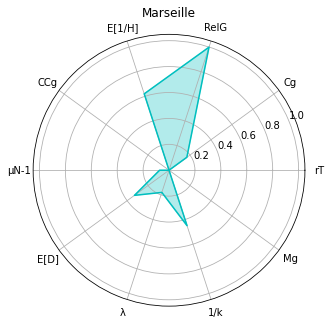

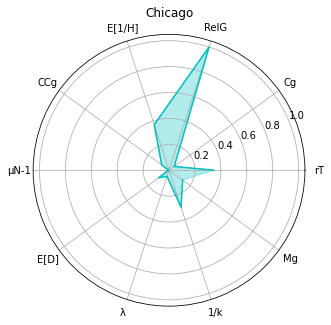

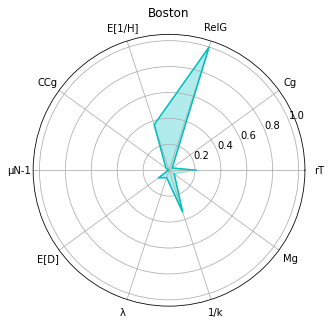

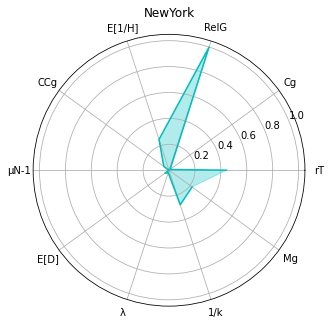

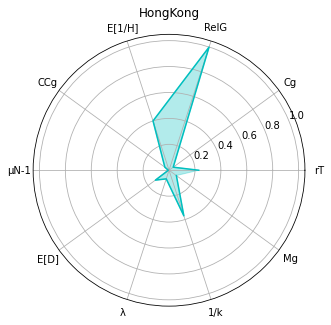

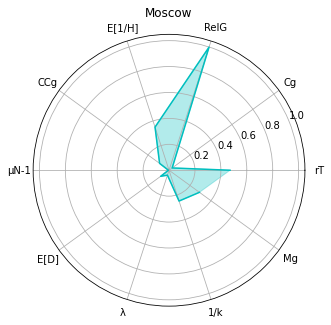

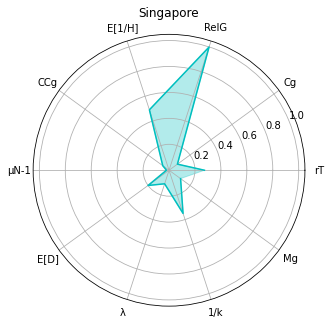

CPU times: user 25.9 s, sys: 3.25 s, total: 29.2 s
Wall time: 14.8 s


In [21]:
%%time

plot_radar(result, ['rT', 'Cg', 'RelG', 'E[1/H]', 'CCg', 'μN-1', 'E[D]', 'λ', '1/k', 'Mg'], save=True)